# Bell states tests
This Jupyter Notebook is used to carry out the dynamical decoupling tests with the Bell (two-qubit) states $|\beta_{ij}\rangle$ and the three simple universal sequences XYXY, XZXZ and YZYZ (and free evolution IIII).

### Load the libraries

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, schedule, transpiler
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.tools import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager

import numpy as np
import matplotlib.pyplot as plt

# For data fitting
from lmfit import Model

### Get the provider with your account id and set the backend (ibmq_lima)

In [2]:
provider = IBMQ.enable_account('your-ibmq-id-here')

In [3]:
backend = provider.get_backend('ibmq_lima')

### Get information about the duration of some of the instructions of the backend

In [4]:
# Get duration of instructions
dt_in_s = backend.configuration().dt
Reset_duration = transpiler.InstructionDurations.from_backend(backend).get("reset",4)
I_duration     = transpiler.InstructionDurations.from_backend(backend).get("id",4)
Z_duration     = transpiler.InstructionDurations.from_backend(backend).get("rz",4)
SX_duration    = transpiler.InstructionDurations.from_backend(backend).get("sx",4)
X_duration     = transpiler.InstructionDurations.from_backend(backend).get("x",4)
Y_duration     = 3*Z_duration + 2*SX_duration
H_duration     = 2*Z_duration + SX_duration
Measurement_duration = transpiler.InstructionDurations.from_backend(backend).get("measure",4)

### Define the function that generates the circuits

In [5]:
def get_transpiled_circuit(num_blocks, backend, 
                           X_duration, Y_duration, dt_in_s,
                           bell_state=[1,0], dynamicalDecoupling=True, sequence="XYXY"): 

    """
    bell_state: [0,0], [0,1], [1,0] or [1,1]
    dynamicalDecoupling: True, False
    sequence: "XYXY", "XZXZ", "YZYZ"
    qubits used -> qubit 3 and qubit 4
    """
    
    # Duration of the 4-gate blocks of the sequences (the duration of a Z gate is 0)
    tau_block = {"XYXY":2*(X_duration+Y_duration),
                 "XZXZ":2*X_duration,
                 "YZYZ":2*Y_duration}
    
    # Initialize the quantum circuit object
    circuit = QuantumCircuit(5, 2)
    
    # Prepare the state
    if bell_state[0] == 1:
        circuit.x(3)
    if bell_state[1] == 1:
        circuit.x(3)
    circuit.h(3)
    circuit.cnot(3,4)
    
    # Apply dynamical decoupling or wait
    if dynamicalDecoupling == True:   
        for i in range(num_blocks): # Put the sequence 4-gate blocks on both qubits
            if sequence == "XYXY":
                circuit.x([3,4])
                circuit.y([3,4])
                circuit.x([3,4])
                circuit.y([3,4])
            elif sequence == "XZXZ":
                circuit.x([3,4])
                circuit.z([3,4])
                circuit.x([3,4])
                circuit.z([3,4])
            elif sequence == "YZYZ":
                circuit.y([3,4])
                circuit.z([3,4])
                circuit.y([3,4])
                circuit.z([3,4])
    elif dynamicalDecoupling == False:
        # Set the number of identity gates in a free evolution block 
        # so that it has the same duration as the block from the 
        # corresponding dynamical decoupling sequence
        num_ids = {"XYXY":6, "XZXZ":2, "YZYZ":4}
        # Build the free evolution part.
        for i in range(num_blocks): # Put the identity gate blocks of the free evolution
            for j in range(num_ids[sequence]):
                circuit.id([3,4]) # How a single block is built
         
    tau_wait  = num_blocks*tau_block[sequence] # Duration of the dynamical decoupling sequence
    wait_duration = tau_wait*dt_in_s*1e6 # Convert the duration from system units (dt) to microseconds
    
    # Decode state back to |00>
    circuit.cnot(3,4)
    circuit.h(3)
    if bell_state[1] == 1:
        circuit.x(3)
    if bell_state[0] == 1:
        circuit.x(3)
        
    # Measure
    circuit.measure(3,0)
    circuit.measure(4,1)
    
    # Transpile the circuit
    transpiled_circuit = transpile(circuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    return transpiled_circuit, wait_duration

### Parameters for creating the tests circuits

In [6]:
max_time   = 15 # In us.
num_steps  = 15 
wait_times = np.linspace(0, max_time, num_steps) # In microseconds.
#print(wait_times)

num_blocks_array    = ((wait_times*1e-6/dt_in_s)/(2*(X_duration + Y_duration))).astype(int) # Number of blocks necessary to fit the wait times.
num_blocks_array_XY = ((wait_times*1e-6/dt_in_s)/(2*(X_duration + Y_duration))).astype(int) # For the XYXY case
num_blocks_array_XZ = ((wait_times*1e-6/dt_in_s)/(2*X_duration)).astype(int)                # For the XZXZ case
num_blocks_array_YZ = ((wait_times*1e-6/dt_in_s)/(2*Y_duration)).astype(int)                # For the YZYZ case

shots = 2**13
#print(shots)

bell_states = [[0,0], [0,1], [1,0], [1,1]]
repetitions = 10

reshape_dims = (len(bell_states), repetitions, 4, num_steps)
#print(reshape_dims)
#print("Total number of circuits:", np.prod(reshape_dims))

### Build the circuits

In [7]:
all_wait_times = []
all_transpiled_circuits = []

"""
Data format: [[[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |β00>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |β01>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |β10>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |β11>]
"""

for i, bell_state in enumerate(bell_states): # Prepare all the circuits.

    repetitions_counts = []
    repetitions_wait_times = []
    
    wait_times_XYXY = []
    wait_times_XZXZ = []
    wait_times_YZYZ = []
    wait_times_IIII = []
    transpiled_circuits_XYXY = []
    transpiled_circuits_XZXZ = []
    transpiled_circuits_YZYZ = []
    transpiled_circuits_IIII = []
    
    state_transpiled_circuits = []

    print("Bell state:", bell_state)
    print("Generating the XYXY circuits...")
    for j, num_blocks in enumerate(num_blocks_array_XY): # Build the XYXY circuits.
        print("\tXYXY", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                               X_duration, Y_duration, dt_in_s,
                                                               bell_state=bell_state, dynamicalDecoupling=True, sequence="XYXY")
        wait_times_XYXY.append(wait_time)
        transpiled_circuits_XYXY.append(tcircuit)
        
    print("Generating the XZXZ circuits...")
    for j, num_blocks in enumerate(num_blocks_array_XZ): # Build the XZXZ circuits.
        print("\tXZXZ", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                               X_duration, Y_duration, dt_in_s,
                                                               bell_state=bell_state, dynamicalDecoupling=True, sequence="XZXZ")
        wait_times_XZXZ.append(wait_time)
        transpiled_circuits_XZXZ.append(tcircuit)
        
    print("Generating the YZYZ circuits...")
    for j, num_blocks in enumerate(num_blocks_array_YZ): # Build the XZXZ circuits.
        print("\tYZYZ", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                               X_duration, Y_duration, dt_in_s,
                                                               bell_state=bell_state, dynamicalDecoupling=True, sequence="YZYZ")
        wait_times_YZYZ.append(wait_time)
        transpiled_circuits_YZYZ.append(tcircuit)
        
    print("Generating the IIII circuits...")
    for j, num_blocks in enumerate(num_blocks_array): # Build the IIII circuits.
        print("\tIIII", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                     X_duration, Y_duration, dt_in_s,
                                                     bell_state=bell_state, dynamicalDecoupling=False)
        wait_times_IIII.append(wait_time)
        transpiled_circuits_IIII.append(tcircuit)

    state_transpiled_circuits.append([transpiled_circuits_XYXY, transpiled_circuits_XZXZ, transpiled_circuits_YZYZ, transpiled_circuits_IIII])
    all_wait_times.append([wait_times_XYXY, wait_times_XZXZ, wait_times_YZYZ, wait_times_IIII])
    
    # Flatten the transpiled circuits to send them in a single job
    circuits_array = np.asarray(state_transpiled_circuits) # Get a 2D array containing the set of circuits for each sequence.
    dimensions = np.shape(circuits_array) # Get the dimensions of the 2D array.
    circuits_array_flattened = circuits_array.flatten() # Make the array 1-dimensional.
    
    print("Building repetitions...")
    for j in range(repetitions):
        print("\tRepetition",j)
        all_transpiled_circuits = all_transpiled_circuits + circuits_array_flattened.tolist()

    print("Done!")
print("Finished!")

Bell state: [0, 0]
Generating the XYXY circuits...
	XYXY 0 1 15
	XYXY 0 2 15
	XYXY 0 3 15
	XYXY 0 4 15
	XYXY 0 5 15
	XYXY 0 6 15
	XYXY 0 7 15
	XYXY 0 8 15
	XYXY 0 9 15
	XYXY 0 10 15
	XYXY 0 11 15
	XYXY 0 12 15
	XYXY 0 13 15
	XYXY 0 14 15
	XYXY 0 15 15
Generating the XZXZ circuits...
	XZXZ 0 1 15
	XZXZ 0 2 15
	XZXZ 0 3 15
	XZXZ 0 4 15
	XZXZ 0 5 15
	XZXZ 0 6 15
	XZXZ 0 7 15
	XZXZ 0 8 15
	XZXZ 0 9 15
	XZXZ 0 10 15
	XZXZ 0 11 15
	XZXZ 0 12 15
	XZXZ 0 13 15
	XZXZ 0 14 15
	XZXZ 0 15 15
Generating the YZYZ circuits...
	YZYZ 0 1 15
	YZYZ 0 2 15
	YZYZ 0 3 15
	YZYZ 0 4 15
	YZYZ 0 5 15
	YZYZ 0 6 15
	YZYZ 0 7 15
	YZYZ 0 8 15
	YZYZ 0 9 15
	YZYZ 0 10 15
	YZYZ 0 11 15
	YZYZ 0 12 15
	YZYZ 0 13 15
	YZYZ 0 14 15
	YZYZ 0 15 15
Generating the IIII circuits...
	IIII 0 1 15
	IIII 0 2 15
	IIII 0 3 15
	IIII 0 4 15
	IIII 0 5 15
	IIII 0 6 15
	IIII 0 7 15
	IIII 0 8 15
	IIII 0 9 15
	IIII 0 10 15
	IIII 0 11 15
	IIII 0 12 15
	IIII 0 13 15
	IIII 0 14 15
	IIII 0 15 15
Building repetitions...
	Repetition 0
	Repetition

C:\Users\usuario\AppData\Local\Temp\ipykernel_18936\4140629893.py:68: FutureWarning: The input object of type 'Delay' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Delay', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  circuits_array = np.asarray(state_transpiled_circuits) # Get a 2D array containing the set of circuits for each sequence.
C:\Users\usuario\AppData\Local\Temp\ipykernel_18936\4140629893.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  circuits_array =

	XYXY 1 5 15
	XYXY 1 6 15
	XYXY 1 7 15
	XYXY 1 8 15
	XYXY 1 9 15
	XYXY 1 10 15
	XYXY 1 11 15
	XYXY 1 12 15
	XYXY 1 13 15
	XYXY 1 14 15
	XYXY 1 15 15
Generating the XZXZ circuits...
	XZXZ 1 1 15
	XZXZ 1 2 15
	XZXZ 1 3 15
	XZXZ 1 4 15
	XZXZ 1 5 15
	XZXZ 1 6 15
	XZXZ 1 7 15
	XZXZ 1 8 15
	XZXZ 1 9 15
	XZXZ 1 10 15
	XZXZ 1 11 15
	XZXZ 1 12 15
	XZXZ 1 13 15
	XZXZ 1 14 15
	XZXZ 1 15 15
Generating the YZYZ circuits...
	YZYZ 1 1 15
	YZYZ 1 2 15
	YZYZ 1 3 15
	YZYZ 1 4 15
	YZYZ 1 5 15
	YZYZ 1 6 15
	YZYZ 1 7 15
	YZYZ 1 8 15
	YZYZ 1 9 15
	YZYZ 1 10 15
	YZYZ 1 11 15
	YZYZ 1 12 15
	YZYZ 1 13 15
	YZYZ 1 14 15
	YZYZ 1 15 15
Generating the IIII circuits...
	IIII 1 1 15
	IIII 1 2 15
	IIII 1 3 15
	IIII 1 4 15
	IIII 1 5 15
	IIII 1 6 15
	IIII 1 7 15
	IIII 1 8 15
	IIII 1 9 15
	IIII 1 10 15
	IIII 1 11 15
	IIII 1 12 15
	IIII 1 13 15
	IIII 1 14 15
	IIII 1 15 15
Building repetitions...
	Repetition 0
	Repetition 1
	Repetition 2
	Repetition 3
	Repetition 4
	Repetition 5
	Repetition 6
	Repetition 7
	Repetition 8
	R

### Send the job to IBMQ (...)

In [ ]:
job_manager = IBMQJobManager()
job_set = job_manager.run(all_transpiled_circuits, backend=backend, name='TwoQubitStatesBell-8192shots-15us-15steps-10reps-q3q4', shots=shots)

Print the id of the job set for being able to retrieve it in the future.

In [ ]:
job_set_id = job_set.job_set_id()
print(job_set_id)

For checking the progress of the jobs:

In [ ]:
statuses = job_set.statuses()
total = len(statuses)
done = 0

for status in statuses:
    if status.name == "DONE":
        done += 1
            
print(f"{done}/{total} jobs done.")
statuses

Get the results.

In [ ]:
results = job_set.results()

Get the counts from the results.

In [ ]:
all_counts_array = np.array([results.get_counts(i) for i in range(len(all_transpiled_circuits))])

### (...) or get the data shown in the paper

In [8]:
all_counts_array = np.load("all_counts_array-TwoQubitStatesBell-8192shots-15us-15steps-10reps-q3q4.npy", allow_pickle=True)

### Reshape the counts to facilitate working with them

In [9]:
"""
Data format: [[[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |β00>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |β01>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |β10>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |β11>]
            
reshape_dims = (number of states considered, repetitions, number of sequences, number of time steps) = (4, 10, 4, 15)
"""

reshaped_counts = all_counts_array.reshape(reshape_dims)
reshaped_counts

array([[[[{'00': 7062, '01': 301, '10': 231, '11': 598},
          {'00': 6713, '01': 368, '10': 364, '11': 747},
          {'00': 6436, '01': 470, '10': 451, '11': 835}, ...,
          {'00': 4253, '01': 1199, '10': 1295, '11': 1445},
          {'00': 4056, '01': 1262, '10': 1309, '11': 1565},
          {'00': 3956, '01': 1357, '10': 1321, '11': 1558}],
         [{'00': 7026, '01': 333, '10': 258, '11': 575},
          {'00': 6666, '01': 369, '10': 401, '11': 756},
          {'00': 6270, '01': 449, '10': 555, '11': 918}, ...,
          {'00': 3834, '01': 1024, '10': 1513, '11': 1821},
          {'00': 3774, '01': 988, '10': 1581, '11': 1849},
          {'00': 3648, '01': 1057, '10': 1649, '11': 1838}],
         [{'00': 7109, '01': 331, '10': 221, '11': 531},
          {'00': 6495, '01': 384, '10': 684, '11': 629},
          {'00': 5757, '01': 477, '10': 1263, '11': 695}, ...,
          {'00': 2360, '01': 1257, '10': 3209, '11': 1366},
          {'00': 2476, '01': 1331, '10': 2984, '11

### Extract the data

Get the raw counts

In [10]:
counts00_bell00_XYXY = np.array([[reshaped_counts[0][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell00_XZXZ = np.array([[reshaped_counts[0][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell00_YZYZ = np.array([[reshaped_counts[0][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell00_IIII = np.array([[reshaped_counts[0][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

counts00_bell01_XYXY = np.array([[reshaped_counts[1][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell01_XZXZ = np.array([[reshaped_counts[1][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell01_YZYZ = np.array([[reshaped_counts[1][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell01_IIII = np.array([[reshaped_counts[1][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

counts00_bell10_XYXY = np.array([[reshaped_counts[2][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell10_XZXZ = np.array([[reshaped_counts[2][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell10_YZYZ = np.array([[reshaped_counts[2][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell10_IIII = np.array([[reshaped_counts[2][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

counts00_bell11_XYXY = np.array([[reshaped_counts[3][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell11_XZXZ = np.array([[reshaped_counts[3][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell11_YZYZ = np.array([[reshaped_counts[3][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell11_IIII = np.array([[reshaped_counts[3][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

raw_counts00 = [[counts00_bell00_XYXY, counts00_bell00_XZXZ, counts00_bell00_YZYZ, counts00_bell00_IIII],
                [counts00_bell01_XYXY, counts00_bell01_XZXZ, counts00_bell01_YZYZ, counts00_bell01_IIII],
                [counts00_bell10_XYXY, counts00_bell10_XZXZ, counts00_bell10_YZYZ, counts00_bell10_IIII],
                [counts00_bell11_XYXY, counts00_bell11_XZXZ, counts00_bell11_YZYZ, counts00_bell11_IIII]]


Get the average of the repetitions

In [11]:
avg_counts00_bell00_XYXY = np.round(np.average(counts00_bell00_XYXY, axis=0)).astype(int)
avg_counts00_bell00_XZXZ = np.round(np.average(counts00_bell00_XZXZ, axis=0)).astype(int)
avg_counts00_bell00_YZYZ = np.round(np.average(counts00_bell00_YZYZ, axis=0)).astype(int)
avg_counts00_bell00_IIII = np.round(np.average(counts00_bell00_IIII, axis=0)).astype(int)

avg_counts00_bell01_XYXY = np.round(np.average(counts00_bell01_XYXY, axis=0)).astype(int)
avg_counts00_bell01_XZXZ = np.round(np.average(counts00_bell01_XZXZ, axis=0)).astype(int)
avg_counts00_bell01_YZYZ = np.round(np.average(counts00_bell01_YZYZ, axis=0)).astype(int)
avg_counts00_bell01_IIII = np.round(np.average(counts00_bell01_IIII, axis=0)).astype(int)

avg_counts00_bell10_XYXY = np.round(np.average(counts00_bell10_XYXY, axis=0)).astype(int)
avg_counts00_bell10_XZXZ = np.round(np.average(counts00_bell10_XZXZ, axis=0)).astype(int)
avg_counts00_bell10_YZYZ = np.round(np.average(counts00_bell10_YZYZ, axis=0)).astype(int)
avg_counts00_bell10_IIII = np.round(np.average(counts00_bell10_IIII, axis=0)).astype(int)

avg_counts00_bell11_XYXY = np.round(np.average(counts00_bell11_XYXY, axis=0)).astype(int)
avg_counts00_bell11_XZXZ = np.round(np.average(counts00_bell11_XZXZ, axis=0)).astype(int)
avg_counts00_bell11_YZYZ = np.round(np.average(counts00_bell11_YZYZ, axis=0)).astype(int)
avg_counts00_bell11_IIII = np.round(np.average(counts00_bell11_IIII, axis=0)).astype(int)

avg_counts00 = [[avg_counts00_bell00_XYXY, avg_counts00_bell00_XZXZ, avg_counts00_bell00_YZYZ, avg_counts00_bell00_IIII],
                [avg_counts00_bell01_XYXY, avg_counts00_bell01_XZXZ, avg_counts00_bell01_YZYZ, avg_counts00_bell01_IIII],
                [avg_counts00_bell10_XYXY, avg_counts00_bell10_XZXZ, avg_counts00_bell10_YZYZ, avg_counts00_bell10_IIII],
                [avg_counts00_bell11_XYXY, avg_counts00_bell11_XZXZ, avg_counts00_bell11_YZYZ, avg_counts00_bell11_IIII]]

Get the maximum count values of the repetitions

In [12]:
max_counts00_bell00_XYXY = np.max(counts00_bell00_XYXY, axis=0)
max_counts00_bell00_XZXZ = np.max(counts00_bell00_XZXZ, axis=0)
max_counts00_bell00_YZYZ = np.max(counts00_bell00_YZYZ, axis=0)
max_counts00_bell00_IIII = np.max(counts00_bell00_IIII, axis=0)

max_counts00_bell01_XYXY = np.max(counts00_bell01_XYXY, axis=0)
max_counts00_bell01_XZXZ = np.max(counts00_bell01_XZXZ, axis=0)
max_counts00_bell01_YZYZ = np.max(counts00_bell01_YZYZ, axis=0)
max_counts00_bell01_IIII = np.max(counts00_bell01_IIII, axis=0)

max_counts00_bell10_XYXY = np.max(counts00_bell10_XYXY, axis=0)
max_counts00_bell10_XZXZ = np.max(counts00_bell10_XZXZ, axis=0)
max_counts00_bell10_YZYZ = np.max(counts00_bell10_YZYZ, axis=0)
max_counts00_bell10_IIII = np.max(counts00_bell10_IIII, axis=0)

max_counts00_bell11_XYXY = np.max(counts00_bell11_XYXY, axis=0)
max_counts00_bell11_XZXZ = np.max(counts00_bell11_XZXZ, axis=0)
max_counts00_bell11_YZYZ = np.max(counts00_bell11_YZYZ, axis=0)
max_counts00_bell11_IIII = np.max(counts00_bell11_IIII, axis=0)

max_counts00 = [[max_counts00_bell00_XYXY, max_counts00_bell00_XZXZ, max_counts00_bell00_YZYZ, max_counts00_bell00_IIII],
                [max_counts00_bell01_XYXY, max_counts00_bell01_XZXZ, max_counts00_bell01_YZYZ, max_counts00_bell01_IIII],
                [max_counts00_bell10_XYXY, max_counts00_bell10_XZXZ, max_counts00_bell10_YZYZ, max_counts00_bell10_IIII],
                [max_counts00_bell11_XYXY, max_counts00_bell11_XZXZ, max_counts00_bell11_YZYZ, max_counts00_bell11_IIII]]

Get the minimum count values of the repetitions

In [15]:
min_counts00_bell00_XYXY = np.min(counts00_bell00_XYXY, axis=0)
min_counts00_bell00_XZXZ = np.min(counts00_bell00_XZXZ, axis=0)
min_counts00_bell00_YZYZ = np.min(counts00_bell00_YZYZ, axis=0)
min_counts00_bell00_IIII = np.min(counts00_bell00_IIII, axis=0)

min_counts00_bell01_XYXY = np.min(counts00_bell01_XYXY, axis=0)
min_counts00_bell01_XZXZ = np.min(counts00_bell01_XZXZ, axis=0)
min_counts00_bell01_YZYZ = np.min(counts00_bell01_YZYZ, axis=0)
min_counts00_bell01_IIII = np.min(counts00_bell01_IIII, axis=0)

min_counts00_bell10_XYXY = np.min(counts00_bell10_XYXY, axis=0)
min_counts00_bell10_XZXZ = np.min(counts00_bell10_XZXZ, axis=0)
min_counts00_bell10_YZYZ = np.min(counts00_bell10_YZYZ, axis=0)
min_counts00_bell10_IIII = np.min(counts00_bell10_IIII, axis=0)

min_counts00_bell11_XYXY = np.min(counts00_bell11_XYXY, axis=0)
min_counts00_bell11_XZXZ = np.min(counts00_bell11_XZXZ, axis=0)
min_counts00_bell11_YZYZ = np.min(counts00_bell11_YZYZ, axis=0)
min_counts00_bell11_IIII = np.min(counts00_bell11_IIII, axis=0)

min_counts00 = [[min_counts00_bell00_XYXY, min_counts00_bell00_XZXZ, min_counts00_bell00_YZYZ, min_counts00_bell00_IIII],
                [min_counts00_bell01_XYXY, min_counts00_bell01_XZXZ, min_counts00_bell01_YZYZ, min_counts00_bell01_IIII],
                [min_counts00_bell10_XYXY, min_counts00_bell10_XZXZ, min_counts00_bell10_YZYZ, min_counts00_bell10_IIII],
                [min_counts00_bell11_XYXY, min_counts00_bell11_XZXZ, min_counts00_bell11_YZYZ, min_counts00_bell11_IIII]]

### Plot the results

0 0
Name     Value   Stderr
C   -0.1128 0.005358
T     31.27   0.8566

0 1
Name     Value   Stderr
C    -0.119  0.01015
T     25.03    1.134

0 2
Name     Value   Stderr
C   -0.1148  0.03748
T      13.1    1.677

0 3
Name     Value   Stderr
C   -0.2065  0.06639
T     16.89    4.143

0 3
Name     Value   Stderr
B      0.6836   0.1295
T       12.04    4.081
f      0.9582 0.0009737
phi     1.313   0.1481

1 0
Name     Value   Stderr
C  -0.08796 0.001969
T     33.22    0.348

1 1
Name     Value   Stderr
C  -0.09588  0.02835
T      14.7    1.466

1 2
Name     Value   Stderr
C  -0.09873  0.01182
T     21.83    1.073

1 3
Name     Value   Stderr
C   -0.2117  0.06124
T     18.63    4.388

1 3
Name     Value   Stderr
B      0.6152   0.1035
T       9.601    2.628
f      0.9571 0.001064
phi     1.238   0.1222

2 0
Name     Value   Stderr
C  -0.09088 0.002749
T     31.69   0.4494

2 1
Name     Value   Stderr
C  -0.08243  0.02443
T     14.55    1.247

2 2
Name     Value   Stderr
C  -0.09497  0.0094

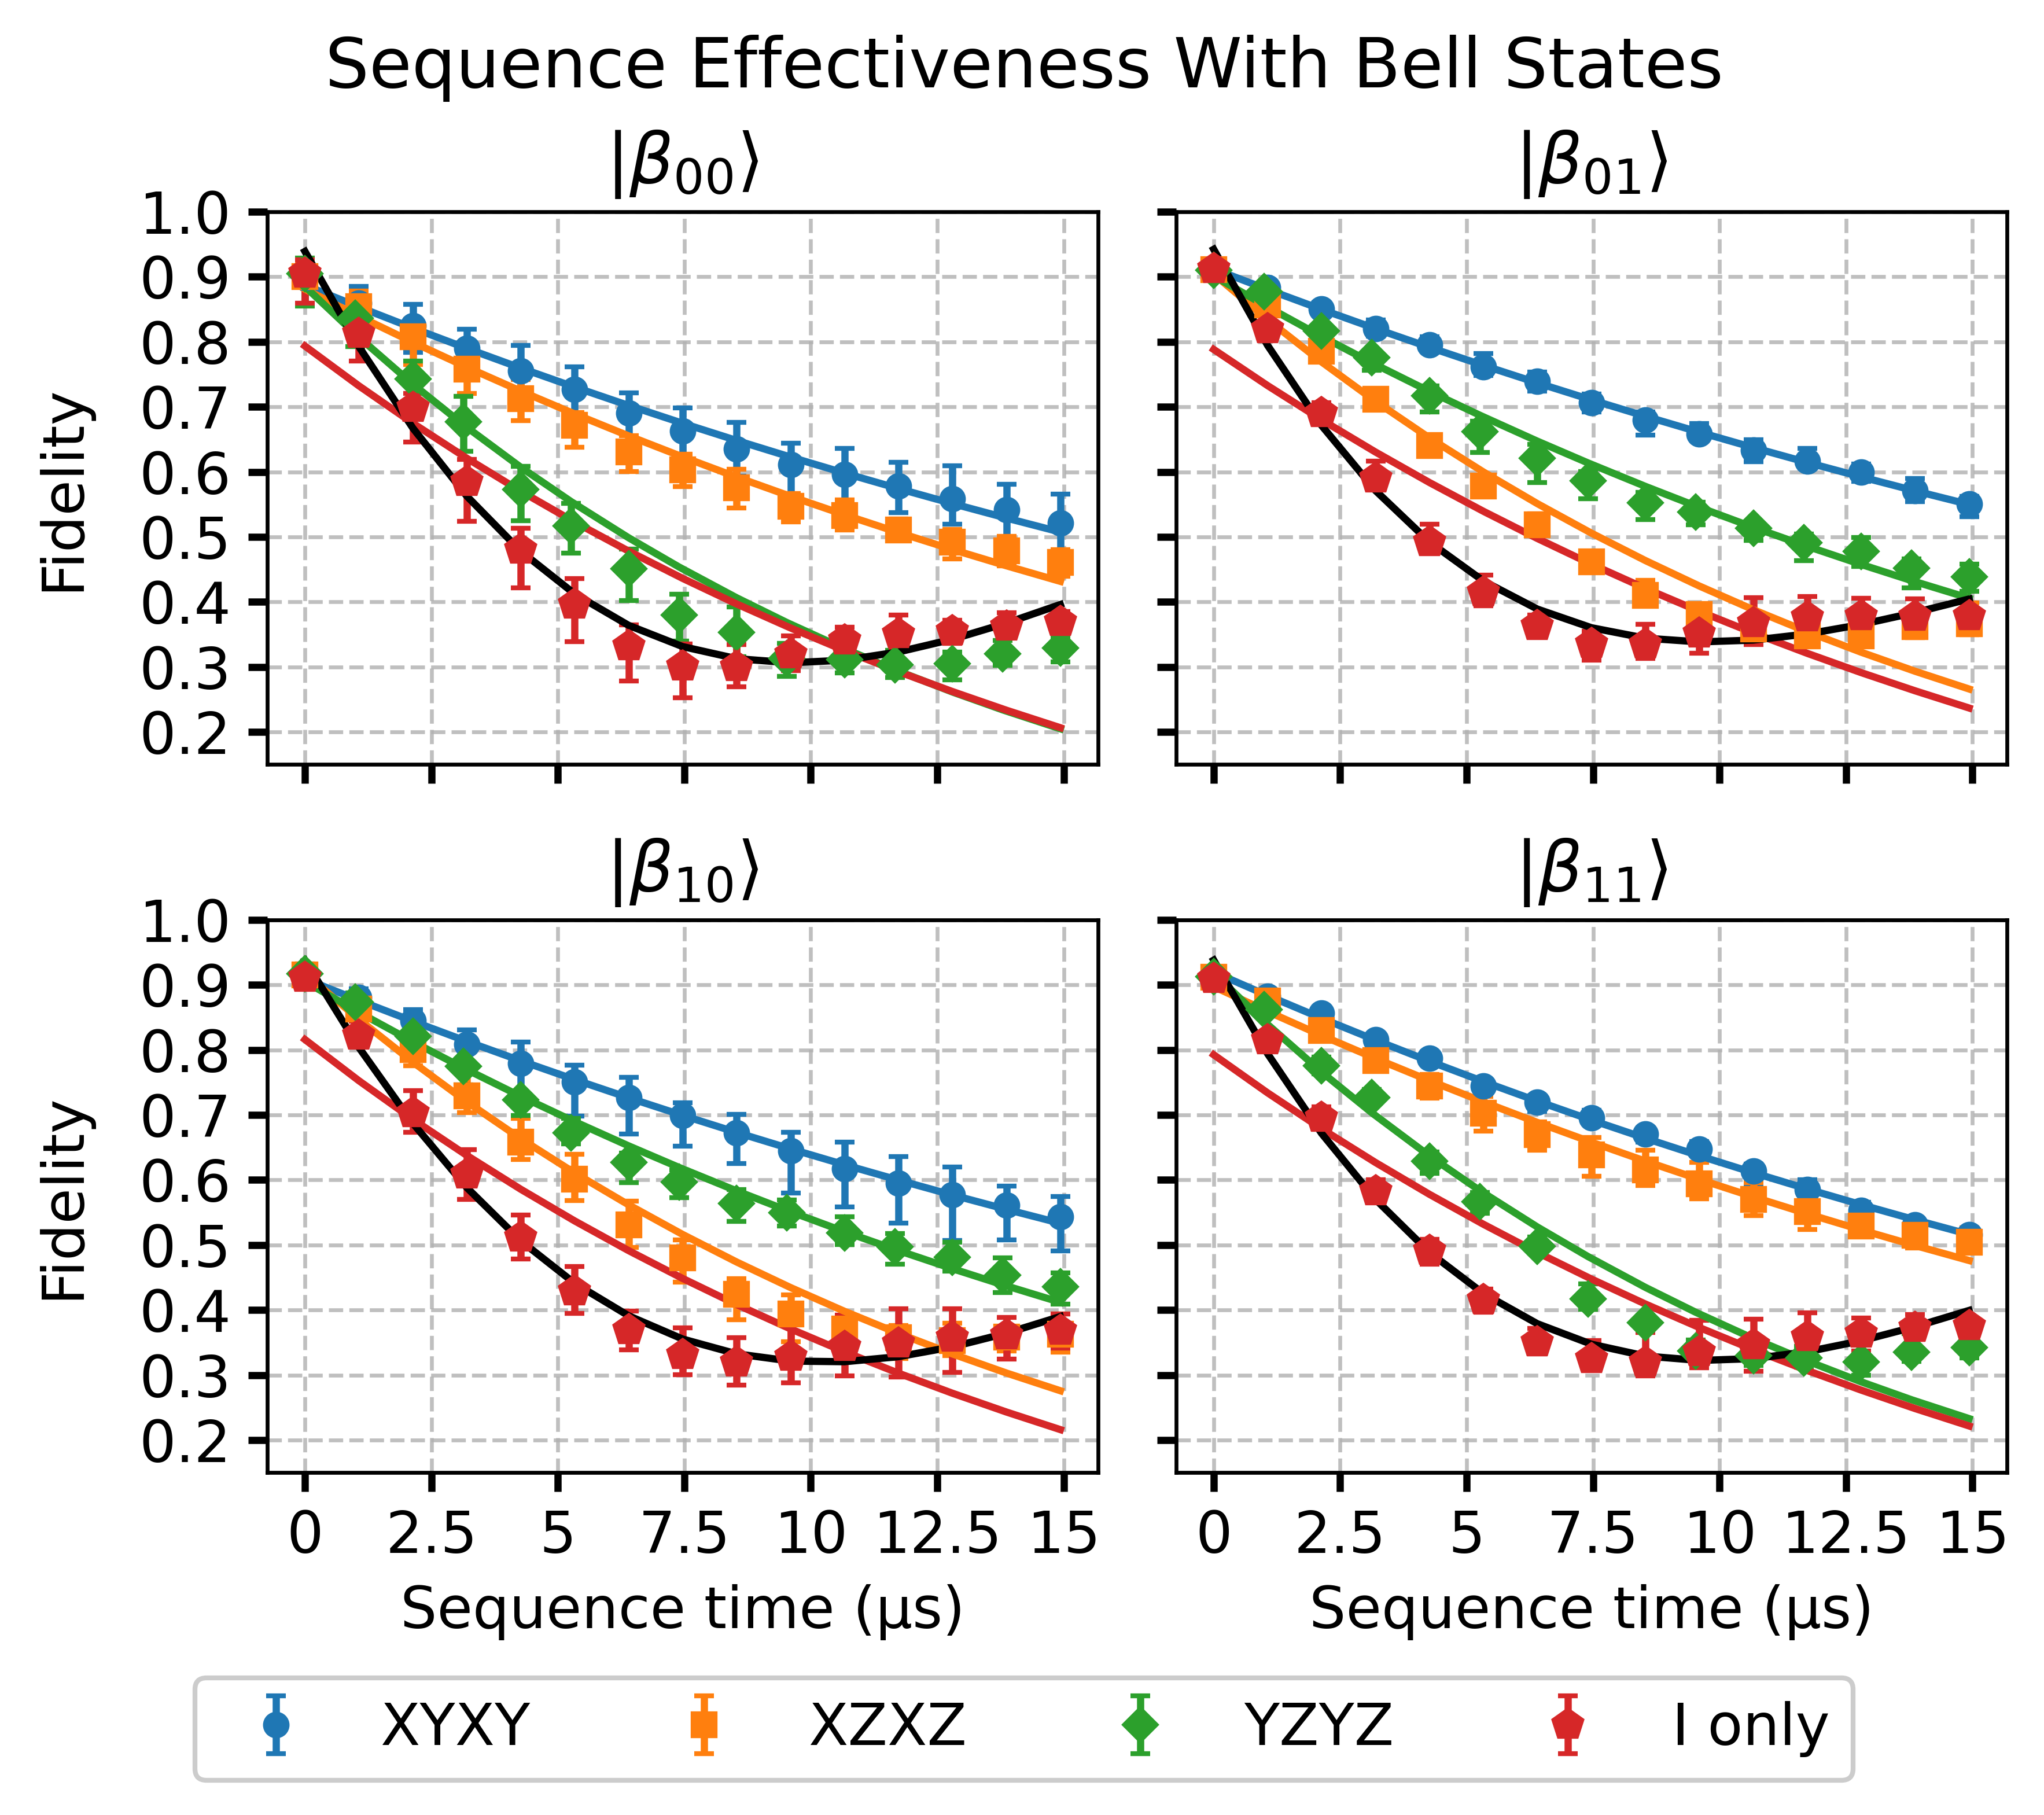

In [16]:
def exp_decay(x, T, C):
    return np.exp(-x/T) + C

def damped_cos(x, T, B, f, phi):
    return np.exp(-x/T)*np.cos(2*np.pi*f*x + phi) + B

bell_labels = ["$|\\beta_{00}\\rangle$", "$|\\beta_{01}\\rangle$", "$|\\beta_{10}\\rangle$", "$|\\beta_{11}\\rangle$"]

fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True, sharex=True, figsize=(6,5), constrained_layout=False, dpi=600)
axs = [axs[i][j] for i in range(2) for j in range(2)]

fig.suptitle("Sequence Effectiveness With Bell States", fontsize="x-large", y=0.955)

axs[0].set_ylabel("Fidelity", labelpad=10, fontsize="large")
axs[2].set_ylabel("Fidelity", labelpad=10, fontsize="large")

msize = 4.5 # Markersize
msize_scatter = 10 # Markersize for scatter plots
medgewidth = 1 # Marker edge width
mtype = "o" # Marker type
mtype_scatter = "_" # Marker type in scatter plots
lw = 1.5 # Line width
elw = 1.5 # Error bar line width
a = 1 # Alpha (transparency)
cs = 2 # Error bar cap size

# Marker options
marker_types = ["o", "s", "D", "p"]
marker_sizes = [msize, msize, msize, 6]

# Plot the results
for i in range(4): # For each state
        
    axs[i].set_title(bell_labels[i], fontsize="x-large")
    axs[i].set_ylim((0.15,1))
    axs[i].set_xticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
    axs[i].set_xticklabels([0, 2.5, 5, 7.5, 10, 12.5, 15], fontsize="large")
    axs[i].set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    axs[i].tick_params(width=1.5, length=4)
    
    # Get the wait times
    t_XYXY = all_wait_times[i][0]
    t_XZXZ = all_wait_times[i][1]
    t_YZYZ = all_wait_times[i][2]
    t_IIII = all_wait_times[i][3]
    
    # Get the fidelities
    fidelity_XYXY = avg_counts00[i][0]/shots
    fidelity_XZXZ = avg_counts00[i][1]/shots
    fidelity_YZYZ = avg_counts00[i][2]/shots
    fidelity_IIII = avg_counts00[i][3]/shots
    
    # For the error bar limits
    min_err_XYXY = np.abs(fidelity_XYXY-min_counts00[i][0]/shots)
    max_err_XYXY = np.abs(fidelity_XYXY-max_counts00[i][0]/shots)
    min_err_XZXZ = np.abs(fidelity_XZXZ-min_counts00[i][1]/shots)
    max_err_XZXZ = np.abs(fidelity_XZXZ-max_counts00[i][1]/shots)
    min_err_YZYZ = np.abs(fidelity_YZYZ-min_counts00[i][2]/shots)
    max_err_YZYZ = np.abs(fidelity_YZYZ-max_counts00[i][2]/shots)
    min_err_IIII = np.abs(fidelity_IIII-min_counts00[i][3]/shots)
    max_err_IIII = np.abs(fidelity_IIII-max_counts00[i][3]/shots)
    
    # Plot the data
    axs[i].errorbar(t_XYXY, fidelity_XYXY, yerr=[min_err_XYXY, max_err_XYXY],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=marker_types[0], markeredgewidth=medgewidth, markersize=marker_sizes[0], 
                alpha=a, c="C0",
                label="XYXY")
    axs[i].errorbar(t_XZXZ, fidelity_XZXZ, yerr=[min_err_XZXZ, max_err_XZXZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=marker_types[1], markeredgewidth=medgewidth, markersize=marker_sizes[1], 
                alpha=a, c="C1",
                label="XZXZ")
    axs[i].errorbar(t_YZYZ, fidelity_YZYZ, yerr=[min_err_YZYZ, max_err_YZYZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=marker_types[2], markeredgewidth=medgewidth, markersize=marker_sizes[2], 
                alpha=a, c="C2",
                label="YZYZ")
    axs[i].errorbar(t_IIII, fidelity_IIII, yerr=[min_err_IIII, max_err_IIII],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=marker_types[3], markeredgewidth=medgewidth, markersize=marker_sizes[3], 
                alpha=a, c="C3",
                label="I only")
    
    # Plot the fits
    for k in range(4):
        state_data = avg_counts00[i][k]/shots
        state_times = all_wait_times[i][k]
        exp_model = Model(exp_decay)
        exp_model.set_param_hint('T', value=20, min=0)
        exp_model.set_param_hint('C', value=-0.1)
        fit_result = exp_model.fit(state_data, x=state_times)
        
        # Print the resulting fit parameters with their standard error
        print(i, k)
        fit_result.params.pretty_print(columns=["value", "stderr"])
        print()
        
        # Plot the curve of the best fit
        ploty = fit_result.best_fit
        axs[i].plot(state_times, ploty, linewidth=lw, alpha=a, c="C"+str(k))
        
        if k==3:  # For the |+> and |-> states add a damped-cosine fit.
            model = Model(damped_cos) # Damped-cosine fit
            model.set_param_hint('T', value=100, min=0)
            model.set_param_hint('B', value=0.8)
            model.set_param_hint('f', value=1)
            model.set_param_hint('phi', value=0)
            fit_result = model.fit(state_data, x=state_times) 
            
            # Print the resulting fit parameters with their standard error
            print(i, k)
            fit_result.params.pretty_print(columns=["value", "stderr"])
            print()
            
            # Plot the curve of the best fit
            ploty = fit_result.best_fit
            axs[i].plot(state_times, ploty, linewidth=1.5, alpha=1, c="k", ls="solid")
            
    axs[i].grid(linestyle="--", alpha=0.8, zorder=0.1)

axs[0].set_yticklabels([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize="large")    
axs[2].set_yticklabels([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize="large")    
axs[2].set_xlabel("Sequence time (μs)", fontsize="large")
axs[3].set_xlabel("Sequence time (μs)", fontsize="large")

# Create the legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.025), fontsize="large", framealpha=1)

# Show
fig.tight_layout()
plt.show()
#plt.savefig(r"fidelityTwoQubit34_Bell.pdf")  